In [6]:
import requests

market = "BTCUSDT"
tick_interval = "1h"

url = f"https://api.binance.com/api/v3/klines?symbol={market}&interval={tick_interval}"
data = requests.get(url).json()


In [40]:
from binance.client import Client
import pandas as pd
from datetime import timedelta, datetime

client = Client()
from_date = datetime.now() - timedelta(days=600)
candles = client.get_historical_klines(
    symbol="BTCUSDT",
    interval=Client.KLINE_INTERVAL_1DAY,
    start_str=from_date.isoformat(),
)

cd = pd.DataFrame(
    candles,
    columns=[
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Close time",
        "Quote asset volume",
        "Number of trades",
        "Taker buy base asset volume",
        "Taker buy quote asset volume",
        "Can be ignored",
    ],
    dtype=float,
)

for i in cd.index:
    cd.at[i, "Date"] = datetime.fromtimestamp(cd.at[i, "Date"] / 1000)

cd.index = pd.DatetimeIndex(cd["Date"])
cd.head(3)


,Date,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
Date,,,,,,,,,,,,
2020-09-11 02:00:00,2020-09-11 02:00:00,10336.86,10397.60,10200.00,10387.89,43830.254467,1.599869e+12,4.512410e+08,637869.0,21231.610727,2.185921e+08,0.0
2020-09-12 02:00:00,2020-09-12 02:00:00,10387.89,10477.97,10269.25,10440.92,35379.153096,1.599955e+12,3.669127e+08,577724.0,17560.768885,1.821487e+08,0.0
2020-09-13 02:00:00,2020-09-13 02:00:00,10440.67,10580.11,10200.00,10332.83,43837.609865,1.600042e+12,4.553386e+08,692439.0,20785.517328,2.159652e+08,0.0


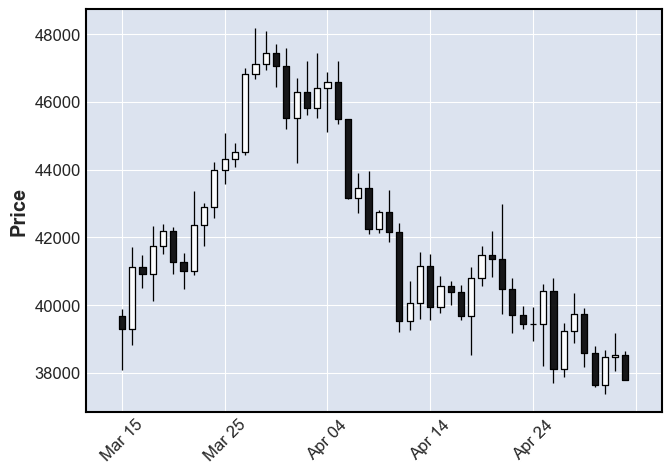

In [41]:
import mplfinance as mpf
from datetime import datetime

chart_data = cd[["Date", "Open", "High", "Low", "Close", "Volume"]]

mpf.plot(chart_data.tail(50), type="candle")

In [42]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting.test import SMA


class SmaCross(SignalStrategy, TrailingStrategy):
    n1 = 20
    n2 = 50

    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()

        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)

        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * 0.95

        # Set order entry sizes using the method provided by
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)

        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)


from backtesting import Backtest
from backtesting.test import GOOG

bt = Backtest(chart_data, SmaCross, cash=100000, commission=0.002)

bt.run()
bt.plot(filename="./results/SmaCross.html")


/var/folders/21/zw56sbb97yj_qzkf5yzv48lh0000gn/T/ipykernel_53520/3190942685.py:41: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='19371', ...)